In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Non-homogeneous data: make it (more) Homogeneous

This section highlights a simple transformation
- Normalization: convert to z-score

that often can be used
- when there are two or more distinct "groups" (clusters) of examples
    - e.g., time-varying price, volume
    
in order to convert the distinct groups into a single homogeneous collection.

## Normalization via z-score

Let's consider a simple dataset with examples that are drawn from two different groups

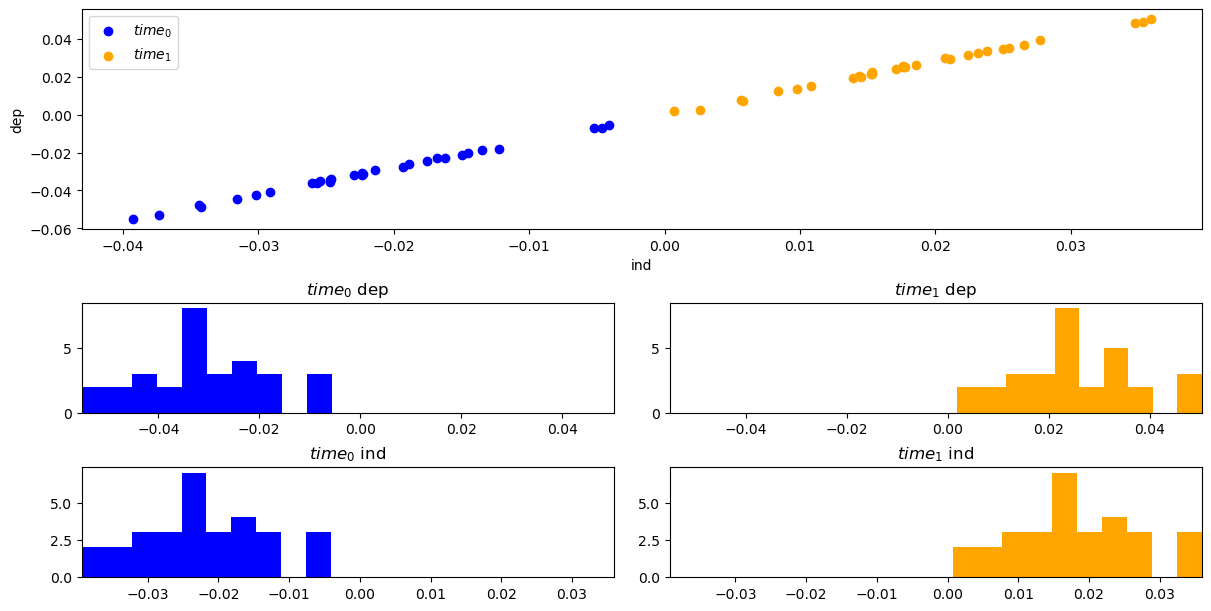

In [7]:
sph = transform_helper.StockReturn_Pooling_Helper()

means = [ -.02, +.02 ]
s = .16/(252**.5)

df_2means = sph.gen_returns(means, [s, s])

_= sph.plot_data(df_2means)

From the top graph: we can see that there is a constant linear relationship
- between target "dep" and feature "ind"
- both within groups and across groups

From the second and third rows, we see the distribution of features and targets
- has same shape between groups
- with different means

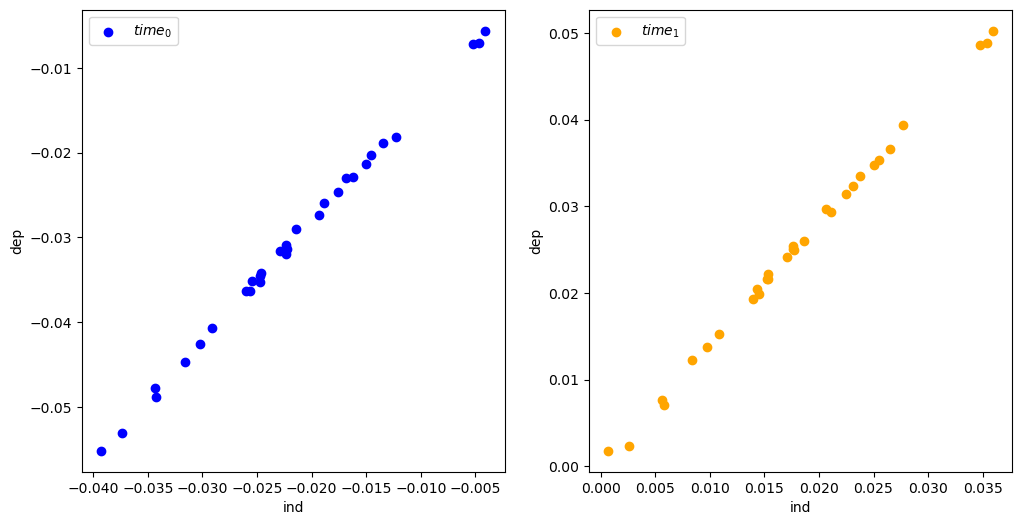

In [8]:
_= sph.plot_segments(df_2means)

Given the simple linear relationship intra-group
- No harm would come from pooling
- Even though the pooled data comes from distinct groups

*However*: it the intra-group relationship was more complex (e.g., a curve)
- pooling would be less successful

So although this example may be over-simplified, we still try to make the distinct groups look similar.

Let's normalize each group
- for each variable (target and feature): turn values into z-scores
    - subtract variable mean, divide by variable standard deviation
    

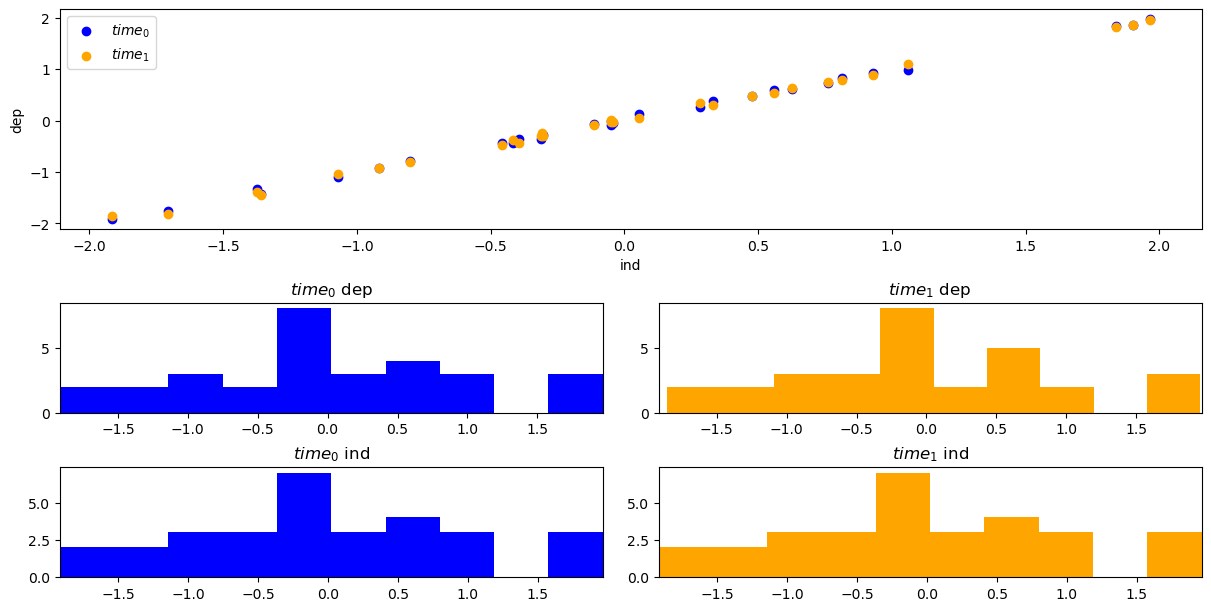

In [9]:
df_2means_norm = sph.normalize_data(df_2means)
_= sph.plot_data(df_2means_norm)

You can now see that the two groups are
- congruent in the top joint plot
- have same distributions in the second and third rows

Non-homogeneous groups made homogeneous !

We can make the separation between groups less trivial by also having different standard deviations per group.

Here's what the data looks like

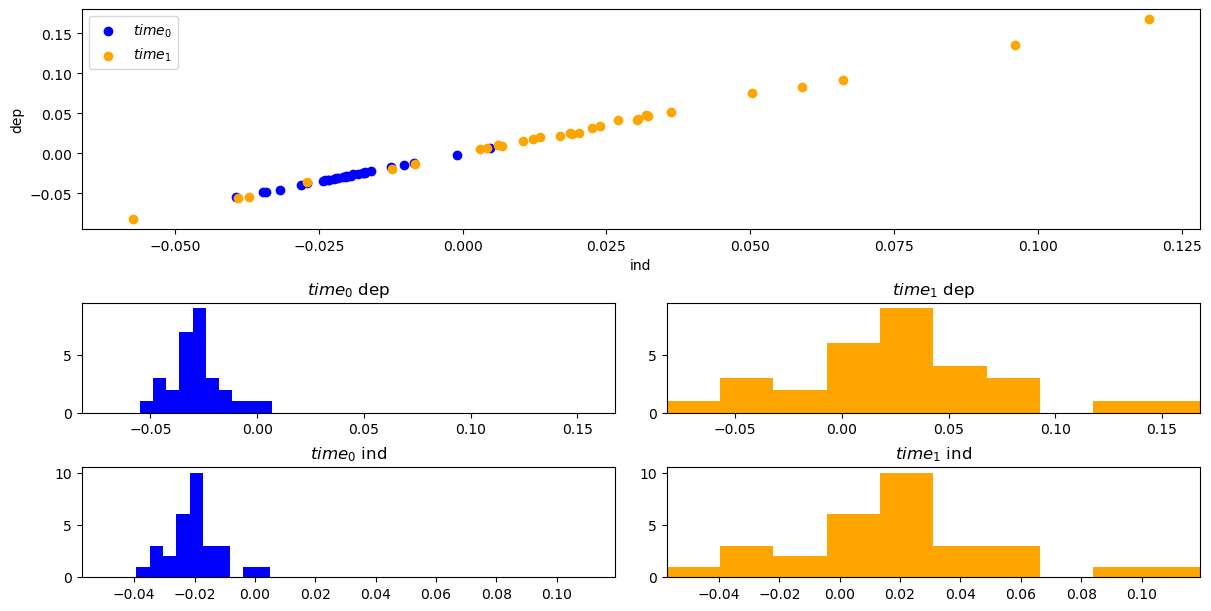

In [10]:
df_2means_2sdevs = sph.gen_returns(means, [s, 4*s])

_= sph.plot_data(df_2means_2sdevs)

Again: normalization does the trick

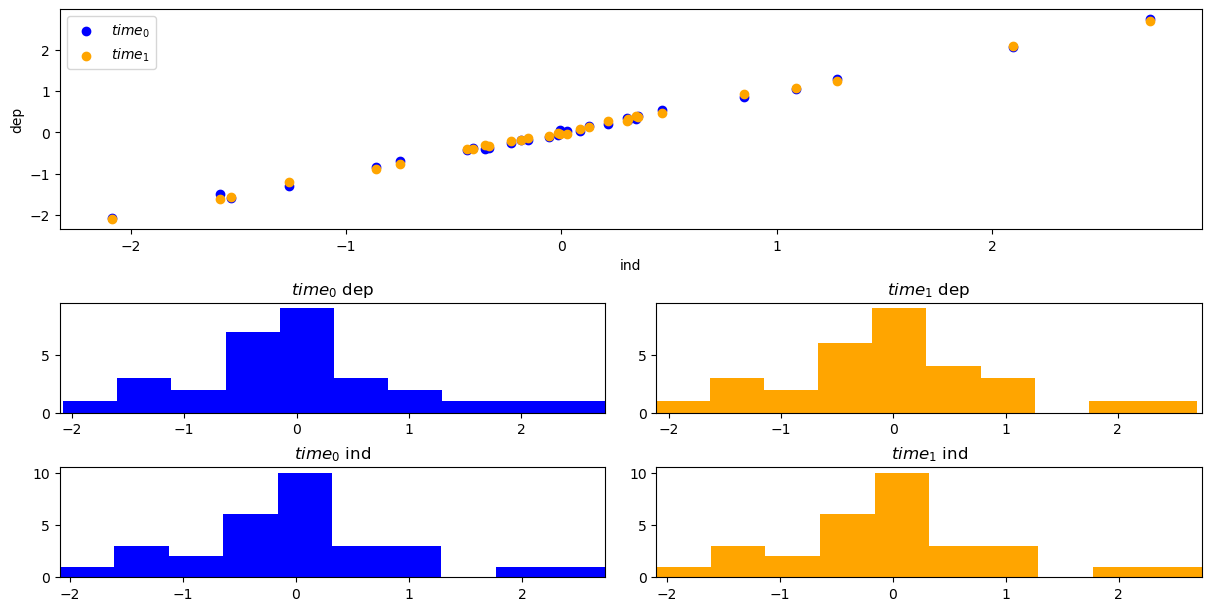

In [11]:
df_2means_2sdevs_norm = sph.normalize_data(df_2means_2sdevs)
_= sph.plot_data(df_2means_2sdevs_norm)

### Pooled over time alternate method: normalization

Let's revisit our "pooled over time" dataset.

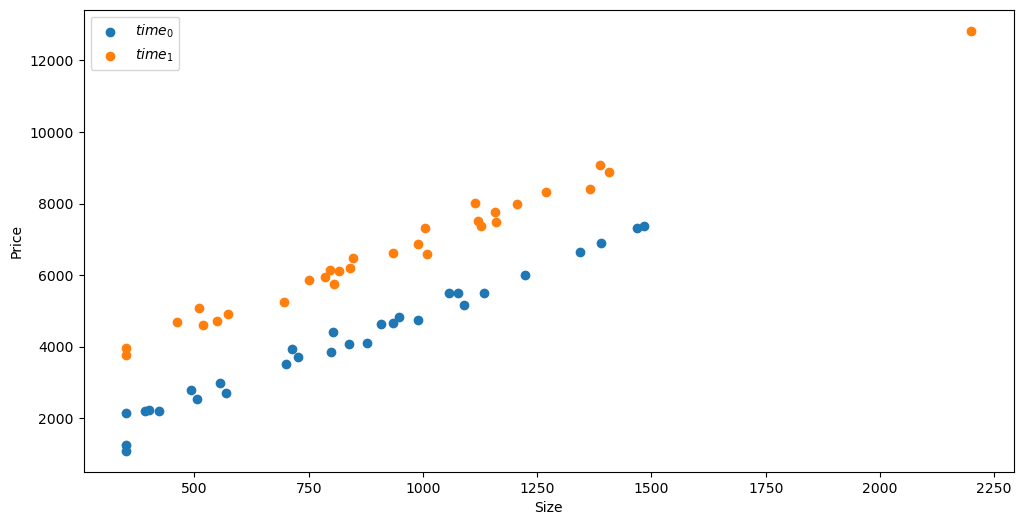

In [12]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig, ax = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax)


We observed that the two groups have the same slope ($\Theta_1$) but different intercepts ($\Theta_0)$
$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$

We had previously addressed this by adding a missing feature
- distinct intercept per group
- by adding a "group indicator" feature

$$
\begin{array}[lll]\\
\y & = & \Theta_{(\text{time}_0)} * \text{Is}_0 + \Theta_{(\text{time}_1)} * \text{Is}_1  + \Theta_1 * \x \\
\end{array}
$$

Which, after dropping one group indicator to avoid the Dummy Variable Trap gave us
$$
\begin{array}[lll]\\
\y & = & \Theta_0 + \Theta'_{(\text{time}_1)} * \text{Is}_1   + \Theta_1 * \x \\
\end{array}
$$

We show an alternate solution using a (trivial) standardization


Some simple algebra allows us to derive the intercept for Linear Regression in terms of the other features

$$
\begin{array} \\
\y^\ip & = & \Theta_0 + \Theta* \x^\ip & \text{hypothesize linear relationship} \\
& & & \Theta \text{ is a vector of non-intercept features, length } \ge 1 \\
\frac{1}{m} \sum_i { \y^\ip } & =  &\frac{1}{m} \sum_i { (\Theta_0 + \Theta * \x^\ip) } & \text{sum over all examples, divide by no. of examples }\\
\bar{\y} & = & \Theta_0 + \Theta * \bar\x & \text{definition of average} \\
\Theta_0 & = & \bar\y - \Theta * \bar\x &  \text{re-arrange terms} \\
\end{array}
$$

That is, the intercept
- is the average target
- less "average prediction"
    - the prediction (excluding intercept) at the average value of all features


Let's standardize the features $\x$ and target $\y$ in our original equations

$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$

giving us the equations
$$
\begin{array}[lll]\\
\tilde\y_{(\text{time}_0)} & = & \tilde\Theta_{(\text{time}_0)} + \tilde\Theta_1 * \tilde\x \\
\tilde\y_{(\text{time}_1)} & = & \tilde\Theta_{(\text{time}_1)} + \tilde\Theta_1 * \tilde\x \\
\end{array}
$$

where the $\tilde\y$ and $\tilde\x$ variables are the standardized forms of $\y$ and $\x$



According to our algebra, when
- the average target
- and the average feature

are both $0$: the intercept is $0$.

Hence are two equations simplify to

$$
\begin{array}[lll]\\
\tilde\y_{(\text{time}_0)} & = & 0 + \tilde\Theta_1 * \tilde\x \\
\tilde\y_{(\text{time}_1)} & = & 0 + \tilde\Theta_1 * \tilde\x \\
\end{array}
$$

That is, a single equation describes both groups
$$
\begin{array}[lll]\\
\tilde\y & = & 0 + \tilde\Theta_1 * \tilde\x \\
\end{array}
$$

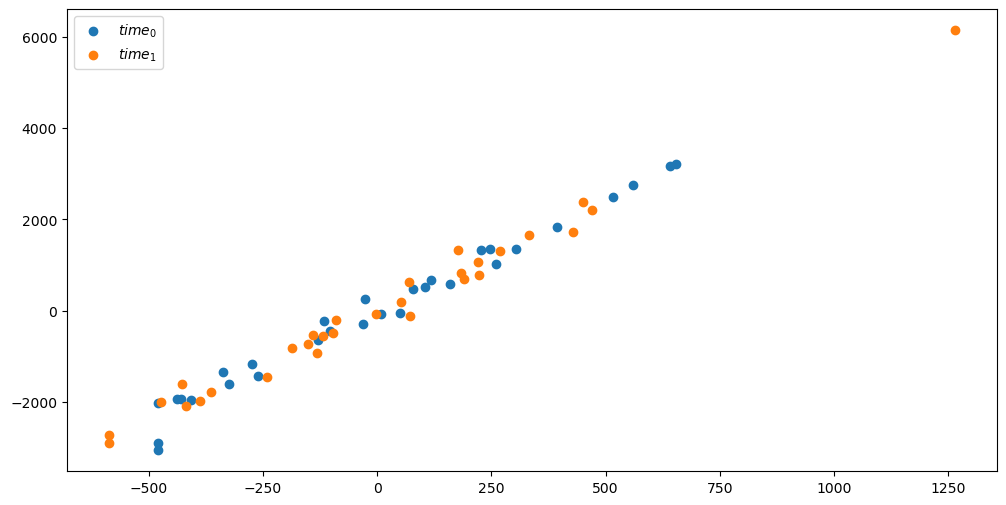

In [13]:


fig, ax = plt.subplots(1,1, figsize=(12,6) )

demean_x0 = sph.x0 - sph.x0.mean()
demean_x1 = sph.x1 - sph.x1.mean()

_= ax.scatter(demean_x0, sph.y0 - sph.y0.mean(), label="$time_0$")
_= ax.scatter(demean_x1, sph.y1 - sph.y1.mean(), label="$time_1$")
_= ax.legend()



Now it looks like each group comes from the same distribution.
- We can pool the observations from the two groups

# Normalization by uncovering the hidden relationship

We illustrate a transformation
- that creates synthetic features
- that capture the "semantics" of the relationship between target and features
    - that is not present at the raw data level
    
This is similar in spirit to our Mortgage Prepayment example
- the synthetic feature "Incentive" captures the semantics of prepayment

Consider the following multi-group data (our multiple geography pooling of data)
- house price as a function of size
- in different geographies

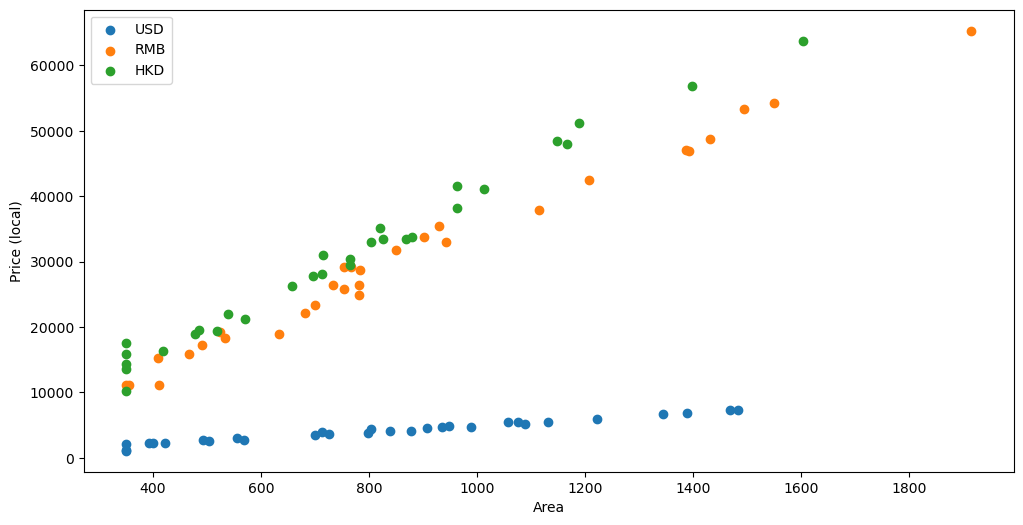

In [14]:
fig_rp

There is clearly a linear relationship intra-group, but the slope differs between groups (local currencies).

$$
\begin{array} \\
\y_g & = & \Theta_{0, g} + \Theta_{1,g} * \x & \text{Equation for group } g \\
& & & g \in \{ \text{USD}, \text{HKD}, \text{RMB} \} \\
& & & \text{Separate parameter vectors } \Theta_g \text{ per group} \\
\end{array}
$$

The apparent diversity in the target may obscure a simple relationship that is common to all groups

Notice that the "units" of the target $\y$ differ for each group
- different currencies

Let's transform the targets to a common unit
- by applying an exchange rate $\beta_g$ to convert currency $g$ into a common currency (USD)
$$
\tilde\y_g = \frac{\y_g}{\beta_g}
$$

Let's re-denominate the target in a common unit.
- Let the target of example $i$ in group $g$ be
$$\y^\ip_g$$
- Change the units in which $\y^\ip_g$ is expressed
- Into a common unit
- Via an "exchange rate" equal to the slope of group $g$
$$
\beta_g
$$
- yielding
$$\tilde{\y}^\ip_g = \frac{\y^\ip_g}{ \beta_g}$$

Here's the re-denominated plot

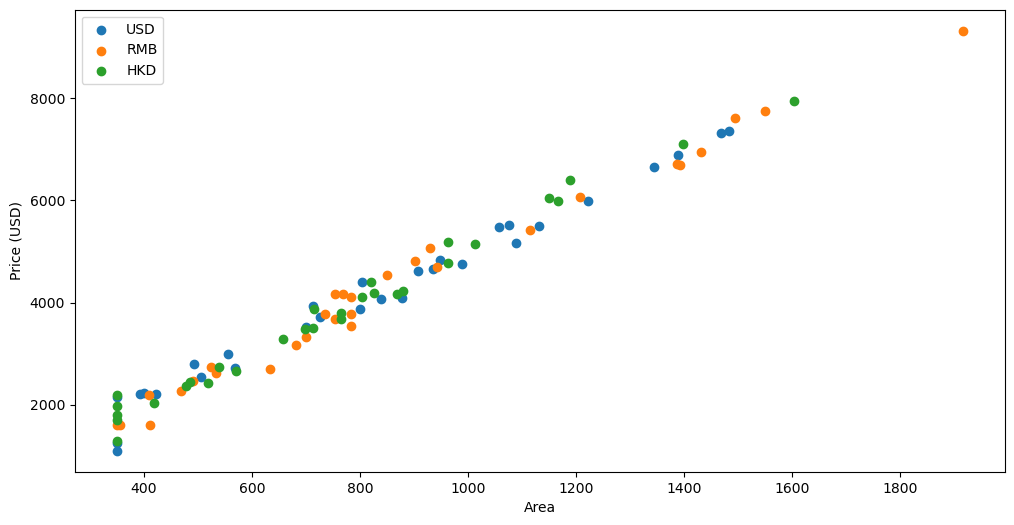

In [15]:
# Relative price levels
rel_price = rph.relative_price()

# Normalize the price of each series by the relative price        
series_normalized = [ series[i]/(1,rel_price[i]) for i in range(len(series))]

fig_rp_norm, ax_rp_norm = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series_normalized, ax=ax_rp_norm, labels=labels, xlabel="Area", ylabel="Price (USD)")

# plt.close(fig_rp_norm)

The three groups are now homogeneous !

$$
\begin{array} \\
\y_g & = & \Theta_{0, g} + \Theta_{1,g} * \x & \text{Equation for group } g \\
& & & g \in \{ \text{USD}, \text{HKD}, \text{RMB} \} \\
& & & \text{Separate parameter vectors } \Theta_g \text{ per group} \\
\frac{\y_g}{\beta_g} & = & \frac{\Theta_{0,g}}{\beta_g} + \frac{\Theta_{1,g}}{\beta_g} * \x & \text{divide by exchange rate} \\
\y & = & \Theta_0 + \Theta_1 * \x \\ \text{Apparantly: } \\ 
& & & \frac{\Theta_{j, g}}{\beta_g} = \Theta_j  & \text{for all } j \\
\end{array}
$$

We have argued that Transformations should be well motivated.

In this case
- the "buying power" of one unit of each currency is different
- by re-denominating in a common currency
- we discover that the relationship is in "buying power" and not "local currency"

We have used "common currency" as a proxy for "buying power".

But there may be better alternative
- "number of months of salary"
    - Interpretation: each additional increment is Size is worth some number of "months of salary"
    - Compensates for differences in salary levels across geographies
- "number of MacDonald's hamburgers"
    - Compensates for differences in price level of a common commodity

It is up to you, the Data Scientist, to propose (and verify) which units reveal the true relationship.

This conversion into common units is a type of *scaling* transformation.
- the common relationship only becomes apparent when the target (or some features) are placed on a common scale
- often see this when target/features are scaled by their standard deviation
    - re-denominate in terms of *number of standard deviations*
    - e.g., returns of two equities are both normal but with different volatilities

# Normalization: creating the correct units

There is a similar need for "re-denomination" that arises in a different context
- when the raw feature
- does not express the key semantics as well as a re-denominated feature

The Geron book has a more sophisticated example of [predicting house Price from features](external/handson-ml2/02_end_to_end_machine_learning_project.ipynb#Experimenting-with-Attribute-Combinations)
- a lot more features

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In terms of predictive value, there are some features
- `total_rooms`, `total_bedrooms`
that are not predictive because their units are not informative
- both features will have greater magnitude in a multi-family house than a single family house

A more meaningful feature can be synthesized by normalizing by the number of families

    housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

That is:
- the normalized variable has units "per household"
- that is more predictive of price than the raw feature

In [17]:
print("Done")

Done
